In [425]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

dataPath = 'house-prices-advanced-regression-techniques'

In [426]:
train = pd.read_csv(dataPath + '/train.csv')
X_train = train.copy()
y_train = X_train.pop('SalePrice')
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

In [427]:
X_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1127,1128,20,RL,182.0,14572,Pave,NaN,IR3,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Family
1424,1425,20,RL,NaN,9503,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,6,2007,WD,Normal
587,588,85,RL,74.0,8740,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
1157,1158,120,RL,34.0,5001,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
938,939,60,RL,73.0,8760,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2006,New,Partial
1224,1225,60,RL,60.0,15384,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
721,722,120,RM,NaN,4426,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
402,403,30,RL,60.0,10200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,NaN,0,8,2008,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
187,188,50,RL,60.0,10410,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal


In [428]:
X_train.shape

(978, 80)

In [429]:
y_train.head()

1127    259000
1424    144000
587     137000
1157    230000
938     239799
Name: SalePrice, dtype: int64

### Put the information about the columns into the dictionary

In [430]:
columnInfo = {}
columnName = ""
descFile = open(dataPath + '/data_description.txt')
for line in descFile:
    if ':' in line:
        columnName, description = line.split(':')
        columnInfo[columnName] = {'desc' : description,
                                  'details' : ''}
    else:
        if len(line) > 2:
            columnInfo[columnName]['details'] += '\n' + line
            
def printInfo(columnName):
    print(columnInfo[columnName]['desc'] + '\n' + columnInfo[columnName]['details'])

In [431]:
printInfo('Street')

 Type of road access to property


       Grvl	Gravel	

       Pave	Paved

       	



### Check null values in columns

In [432]:
percentageOfNull = X_train.isna().mean() * 100

In [433]:
percentageOfNull = percentageOfNull.sort_values(ascending=False)

In [434]:
percentageOfNull[:10]

PoolQC         99.693252
MiscFeature    95.603272
Alley          93.967280
Fence          81.492843
FireplaceQu    46.421268
LotFrontage    18.200409
GarageType      5.112474
GarageYrBlt     5.112474
GarageQual      5.112474
GarageCond      5.112474
dtype: float64

### Let's examine first 6 columns and their influence on cell price

In [435]:
NAFeatures = list(percentageOfNull[:6].index)
for columnName in NAFeatures:
    printInfo(columnName)

 Pool quality


		

       Ex	Excellent

       Gd	Good

       TA	Average/Typical

       Fa	Fair

       NA	No Pool

		

 Miscellaneous feature not covered in other categories


		

       Elev	Elevator

       Gar2	2nd Garage (if not described in garage section)

       Othr	Other

       Shed	Shed (over 100 SF)

       TenC	Tennis Court

       NA	None

		

 Type of alley access to property


       Grvl	Gravel

       Pave	Paved

       NA 	No alley access

		

 Fence quality


		

       GdPrv	Good Privacy

       MnPrv	Minimum Privacy

       GdWo	Good Wood

       MnWw	Minimum Wood/Wire

       NA	No Fence

 Fireplace quality


       Ex	Excellent - Exceptional Masonry Fireplace

       Gd	Good - Masonry Fireplace in main level

       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement

       Fa	Fair - Prefabricated Fireplace in basement

       Po	Poor - Ben Franklin Stove

       NA	No Fireplace

		

 Linear feet of street connected to 

In [436]:
X_train = pd.concat([X_train, y_train], axis=1)#restore SalePrice in order to use relplot

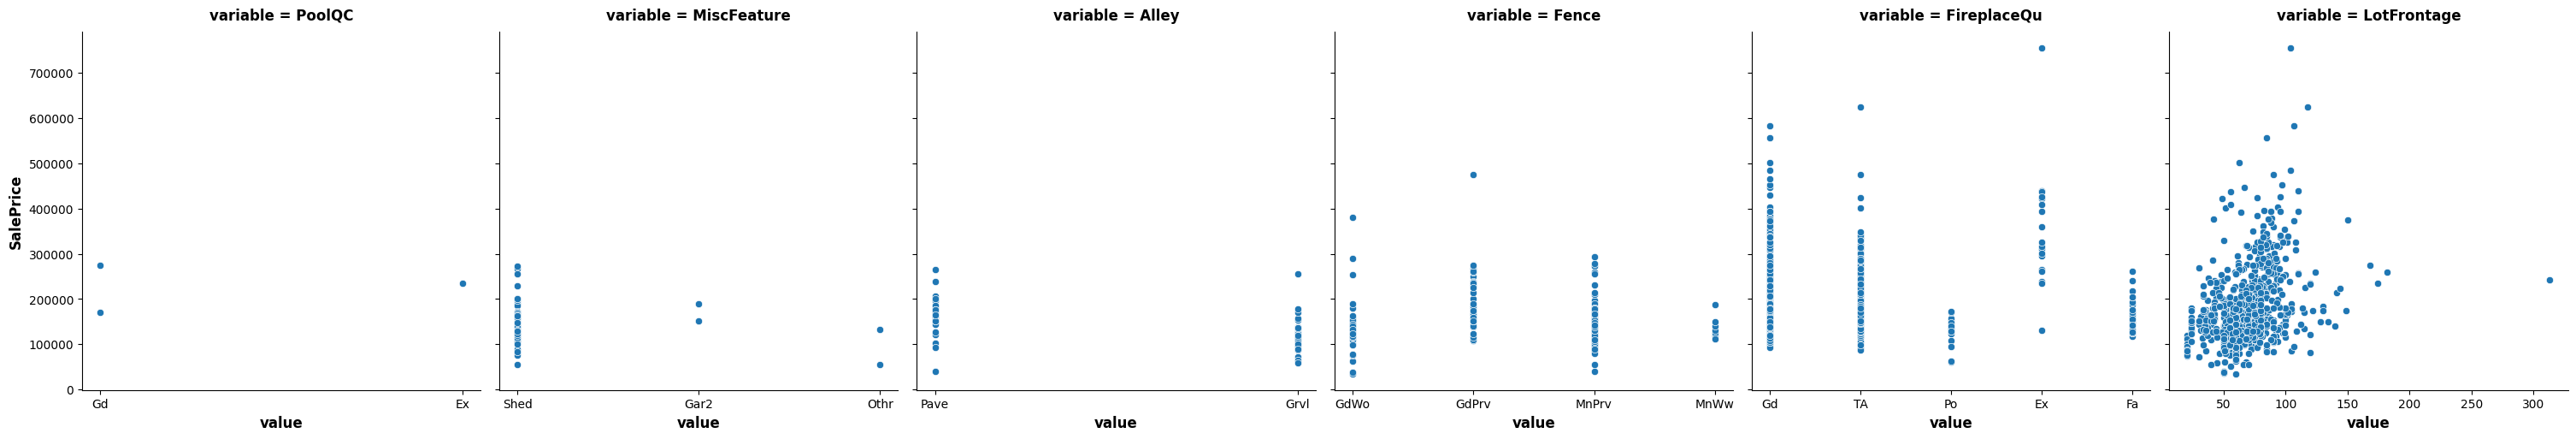

In [437]:
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
NAFeatures = list(percentageOfNull[:6].index)

sns.relplot(
    x="value", y="SalePrice", col="variable", data=X_train.melt(id_vars="SalePrice", value_vars=NAFeatures), facet_kws=dict(sharex=False),
);

### We can safely get rid of first feature since it gives us no information about the Price (in addition, there are only  6 non-NA values). The next 4 features looks like relevant since we can see that there is some pattern in prices for different categories. The last feature looks like pretty reasonable feature to include in model.

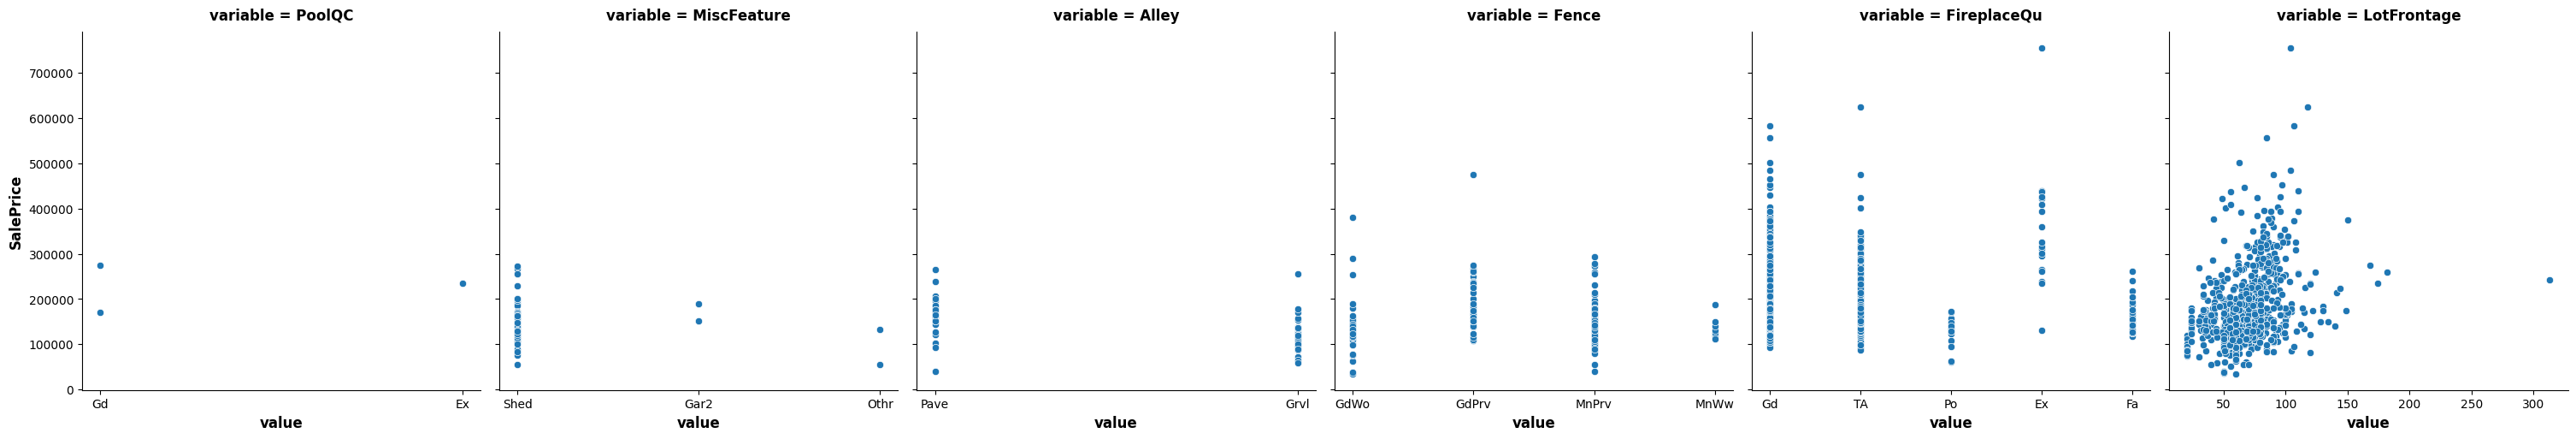

In [438]:
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.relplot(
    x="value", y="SalePrice", col="variable", data=X_train.melt(id_vars="SalePrice", value_vars=NAFeatures), facet_kws=dict(sharex=False),
);

In [439]:
X_train.pop('SalePrice')

1127    259000
1424    144000
587     137000
1157    230000
938     239799
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 978, dtype: int64

In [440]:
NAFeatures

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

In [441]:
def make_mi_scores(X, y):
    X = X.copy()
    if 'SalePrice' in X.columns.tolist():
        X.pop('SalePrice')
    numericColumns =  X.select_dtypes('number').columns.tolist()
    X[numericColumns] = X[numericColumns].fillna(-1)
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [442]:
scores = make_mi_scores(X_train[NAFeatures], y_train)
scores

FireplaceQu    0.234771
LotFrontage    0.201774
Fence          0.051065
Alley          0.044496
PoolQC         0.000000
MiscFeature    0.000000
Name: MI Scores, dtype: float64

In [443]:
scores = make_mi_scores(X_train[X_train.columns.tolist()], y_train)
scores

OverallQual     0.534741
Neighborhood    0.483575
GrLivArea       0.480525
TotalBsmtSF     0.386934
GarageCars      0.377923
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
Id              0.000000
Name: MI Scores, Length: 80, dtype: float64

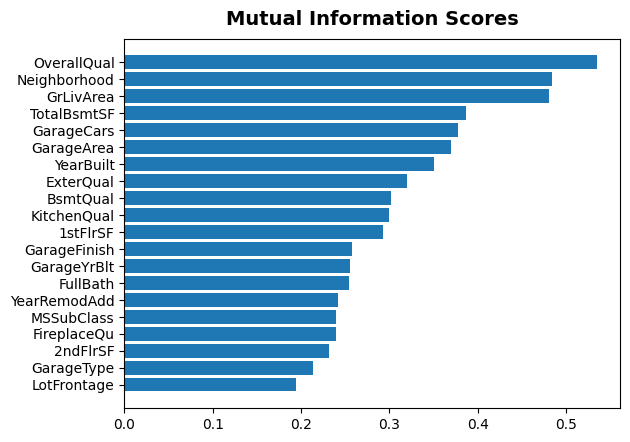

In [444]:
plot_mi_scores(scores[:20])

### As we can see, FireplaceQu and LotFrontage are in top20 columns worth including in model based on mutual score. We will exclude only PoolQC column since the remaining 3 columns can be pretty helpful

In [445]:
X_train.drop(['PoolQC'], axis=1, inplace=True)
X_test.drop(['PoolQC'], axis=1, inplace=True)

In [446]:
X_train.shape

(978, 79)

### Then we should find out how to handle missing values (look into description of each column with missing values)

In [447]:
percentageOfNull = X_train.isna().mean() * 100
percentageOfNull = percentageOfNull.sort_values(ascending=False)
percentageOfNull[:20]

MiscFeature     95.603272
Alley           93.967280
Fence           81.492843
FireplaceQu     46.421268
LotFrontage     18.200409
GarageYrBlt      5.112474
GarageCond       5.112474
GarageType       5.112474
GarageFinish     5.112474
GarageQual       5.112474
BsmtFinType2     2.453988
BsmtFinType1     2.351738
BsmtExposure     2.351738
BsmtCond         2.351738
BsmtQual         2.351738
MasVnrType       0.511247
MasVnrArea       0.511247
Electrical       0.102249
BedroomAbvGr     0.000000
KitchenAbvGr     0.000000
dtype: float64

### We can see that only 18 columns have missing values so we can examine each one and choose proper imputation technique

In [448]:
printInfo('MiscFeature')

 Miscellaneous feature not covered in other categories


		

       Elev	Elevator

       Gar2	2nd Garage (if not described in garage section)

       Othr	Other

       Shed	Shed (over 100 SF)

       TenC	Tennis Court

       NA	None

		



#### For this one we can just impute constant

In [449]:
X_train['MiscFeature'].fillna('None', inplace=True)

In [450]:
printInfo('Alley')

 Type of alley access to property


       Grvl	Gravel

       Pave	Paved

       NA 	No alley access

		



#### The same

In [451]:
X_train['Alley'].fillna('None', inplace=True)

In [452]:
printInfo('Fence')

 Fence quality


		

       GdPrv	Good Privacy

       MnPrv	Minimum Privacy

       GdWo	Good Wood

       MnWw	Minimum Wood/Wire

       NA	No Fence



In [453]:
X_train['Fence'].fillna('None', inplace=True) #The same

In [454]:
printInfo('FireplaceQu')

 Fireplace quality


       Ex	Excellent - Exceptional Masonry Fireplace

       Gd	Good - Masonry Fireplace in main level

       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement

       Fa	Fair - Prefabricated Fireplace in basement

       Po	Poor - Ben Franklin Stove

       NA	No Fireplace

		



In [455]:
X_train['FireplaceQu'].fillna('None', inplace=True) #The same

In [456]:
printInfo('LotFrontage')

 Linear feet of street connected to property




#### This one is tough, since I don't know whether NA means that there is 0 feet connected to property or there is some other reason behind that. So I'll just impute it with 0 since the min in this column is > 0

In [457]:
X_train['LotFrontage'].fillna(0, inplace=True)

In [458]:
printInfo('GarageYrBlt')

 Year garage was built


		



#### This and the next 4 columns contain NA if there is no garage (my assumption), since they have the same number of NA values. Let's create new column and fill it with 1 if there is no garage, and 0 otherwise. And, also, fill NA with some constant since some algorithms don't allow NAs to be present

In [459]:
X_train['noGarage'] = np.where(X_train['GarageYrBlt'].isna(), True, False)
X_train['GarageYrBlt'].fillna(0, inplace=True)
X_train['GarageCond'].fillna('NA', inplace=True)
X_train['GarageType'].fillna('NA', inplace=True)
X_train['GarageFinish'].fillna('NA', inplace=True)
X_train['GarageQual'].fillna('NA', inplace=True)

In [460]:
printInfo('BsmtFinType2')

 Rating of basement finished area (if multiple types)


       GLQ	Good Living Quarters

       ALQ	Average Living Quarters

       BLQ	Below Average Living Quarters	

       Rec	Average Rec Room

       LwQ	Low Quality

       Unf	Unfinshed

       NA	No Basement



#### Let's do the same for this column

In [461]:
X_train['noBsmntType2'] = np.where(X_train['BsmtFinType2'].isna(), True, False)
X_train['BsmtFinType2'].fillna('NA', inplace=True)

In [462]:
printInfo('BsmtFinType1')

 Rating of basement finished area


       GLQ	Good Living Quarters

       ALQ	Average Living Quarters

       BLQ	Below Average Living Quarters	

       Rec	Average Rec Room

       LwQ	Low Quality

       Unf	Unfinshed

       NA	No Basement

		



#### Let's do the same for the next 4 columns (the same amount of NAs)

In [463]:
X_train['noBsmntType1'] = np.where(X_train['BsmtFinType1'].isna(), True, False)
X_train['BsmtFinType1'].fillna('NA', inplace=True)
X_train['BsmtExposure'].fillna('NA', inplace=True)
X_train['BsmtCond'].fillna('NA', inplace=True)
X_train['BsmtQual'].fillna('NA', inplace=True)

In [464]:
printInfo("MasVnrType")

 Masonry veneer type


       BrkCmn	Brick Common

       BrkFace	Brick Face

       CBlock	Cinder Block

       None	None

       Stone	Stone



#### The same for this and the next column

In [465]:
X_train['noMasVnr'] = np.where(X_train['MasVnrType'].isna(), True, False)
X_train['MasVnrType'].fillna('NA', inplace=True)
X_train['MasVnrArea'].fillna(0, inplace=True)

In [466]:
printInfo('Electrical')

 Electrical system


       SBrkr	Standard Circuit Breakers & Romex

       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	

       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)

       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)

       Mix	Mixed

		



#### I don't know the reason behind having NAs in this column so I impute it with the most frequent value

In [467]:
X_train['Electrical'].value_counts()

SBrkr    890
FuseA     67
FuseF     17
FuseP      2
Mix        1
Name: Electrical, dtype: int64

In [468]:
X_train['Electrical'].fillna('SBrkr', inplace=True)

### Let's check now if there is any NAs in the dataset

In [469]:
X_train.isna().sum().sum()

0

### Now we will do the same operations for the test part of the dataset

In [470]:
X_test['MiscFeature'].fillna('None', inplace=True)
X_test['Alley'].fillna('None', inplace=True)
X_test['Fence'].fillna('None', inplace=True)
X_test['FireplaceQu'].fillna('None', inplace=True)
X_test['LotFrontage'].fillna(0, inplace=True)
X_test['noGarage'] = np.where(X_test['GarageYrBlt'].isna(), True, False)
X_test['GarageYrBlt'].fillna(0, inplace=True)
X_test['GarageCond'].fillna('NA', inplace=True)
X_test['GarageType'].fillna('NA', inplace=True)
X_test['GarageFinish'].fillna('NA', inplace=True)
X_test['GarageQual'].fillna('NA', inplace=True)
X_test['noBsmntType2'] = np.where(X_test['BsmtFinType2'].isna(), True, False)
X_test['BsmtFinType2'].fillna('NA', inplace=True)
X_test['noBsmntType1'] = np.where(X_test['BsmtFinType1'].isna(), True, False)
X_test['BsmtFinType1'].fillna('NA', inplace=True)
X_test['BsmtExposure'].fillna('NA', inplace=True)
X_test['BsmtCond'].fillna('NA', inplace=True)
X_test['BsmtQual'].fillna('NA', inplace=True)
X_test['noMasVnr'] = np.where(X_test['MasVnrType'].isna(), True, False)
X_test['MasVnrType'].fillna('NA', inplace=True)
X_test['MasVnrArea'].fillna(0, inplace=True)
X_test['Electrical'].fillna('SBrkr', inplace=True)

In [471]:
X_test.isna().sum().sum()

0

### Let's examine out most promising features

In [472]:
X_train[scores.index[:20]].describe()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,YearBuilt,1stFlrSF,GarageYrBlt,FullBath,YearRemodAdd,MSSubClass,2ndFlrSF,LotFrontage
count,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000
mean,6.088957,1524.160532,1059.925358,1.771984,471.437628,1971.118609,1163.935583,1877.060327,1.579755,1984.677914,56.457055,354.278119,57.134969
std,1.365334,518.449446,412.202176,0.733852,208.928849,30.278547,375.005713,436.599071,0.543199,20.545616,42.196580,441.984591,34.146685
min,1.000000,334.000000,0.000000,0.000000,0.000000,1872.000000,334.000000,0.000000,0.000000,1950.000000,20.000000,0.000000,0.000000
25%,5.000000,1141.250000,806.000000,1.000000,331.500000,1954.000000,884.250000,1958.000000,1.000000,1967.000000,20.000000,0.000000,42.000000
50%,6.000000,1479.000000,995.000000,2.000000,478.000000,1973.000000,1095.500000,1977.000000,2.000000,1993.000000,50.000000,0.000000,63.000000
75%,7.000000,1791.500000,1283.250000,2.000000,576.000000,2000.000000,1391.000000,2001.000000,2.000000,2003.000000,70.000000,733.500000,79.750000
max,10.000000,4676.000000,3206.000000,4.000000,1356.000000,2010.000000,3228.000000,2010.000000,3.000000,2010.000000,190.000000,1872.000000,313.000000


### Let's scale all numeric features

In [473]:
numericColumns =  X_train.select_dtypes('number').columns.tolist()
numericColumns

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [474]:
numericColumns.remove('Id')

In [475]:
X_train_normalized = X_train.copy()
scaler = StandardScaler()
scaler = scaler.fit(X_train_normalized[numericColumns])
X_train_normalized[numericColumns] = scaler.transform(X_train_normalized[numericColumns])
X_train_normalized[scores.index[:20]].describe()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,YearBuilt,1stFlrSF,GarageYrBlt,FullBath,YearRemodAdd,MSSubClass,2ndFlrSF,LotFrontage
count,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02,9.780000e+02
mean,-7.991789e-17,1.925295e-16,-1.979784e-16,-3.632632e-17,1.053463e-16,-2.973309e-15,-1.925295e-16,-2.597332e-16,-2.906105e-17,4.496290e-15,-8.173421e-17,1.017137e-16,1.080708e-16
std,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00,1.000512e+00
min,-3.729170e+00,-2.296790e+00,-2.572688e+00,-2.415869e+00,-2.257605e+00,-3.275234e+00,-2.214260e+00,-4.301477e+00,-2.909728e+00,-1.688713e+00,-8.644233e-01,-8.019723e-01,-1.674078e+00
25%,-7.979839e-01,-7.389466e-01,-6.163366e-01,-1.052499e+00,-6.701287e-01,-5.656602e-01,-7.461984e-01,1.854816e-01,-1.067842e+00,-8.608629e-01,-8.644233e-01,-8.019723e-01,-4.434607e-01
50%,-6.518742e-02,-8.715148e-02,-1.575891e-01,3.108706e-01,3.142567e-02,6.216788e-02,-1.825855e-01,2.290220e-01,7.740442e-01,4.052613e-01,-1.531015e-01,-8.019723e-01,1.718478e-01
75%,6.676090e-01,5.159158e-01,5.420614e-01,3.108706e-01,5.007249e-01,9.543446e-01,6.058057e-01,2.840205e-01,7.740442e-01,8.922322e-01,3.211131e-01,8.584370e-01,6.626295e-01
max,2.865998e+00,6.082468e+00,5.209028e+00,3.037610e+00,4.235963e+00,1.284780e+00,5.506904e+00,3.046449e-01,2.615931e+00,1.233112e+00,3.166400e+00,3.435637e+00,7.496949e+00


In [476]:
X_train_normalized.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,noGarage,noBsmntType2,noBsmntType1,noMasVnr
1127,1128,-0.864423,RL,3.658596,0.376557,Pave,None,IR3,Lvl,AllPub,...,None,-0.096291,1.758775,-0.616150,WD,Family,False,False,False,False
1424,1425,-0.864423,RL,-1.674078,-0.107533,Pave,None,Reg,Lvl,AllPub,...,None,-0.096291,-0.104399,-0.616150,WD,Normal,False,False,False,False
587,588,0.676774,RL,0.494152,-0.180399,Pave,None,IR1,Lvl,AllPub,...,None,-0.096291,0.268236,0.868074,WD,Normal,False,False,False,False
1157,1158,1.506649,RL,-0.677864,-0.537473,Pave,None,IR1,Lvl,AllPub,...,None,-0.096291,0.268236,0.868074,WD,Normal,False,False,False,False
938,939,0.084006,RL,0.464852,-0.178489,Pave,None,Reg,Lvl,AllPub,...,None,-0.096291,0.640871,-1.358262,New,Partial,False,False,False,False


In [477]:
X_test_normalized = X_test.copy()
X_test_normalized[numericColumns] = scaler.transform(X_test_normalized[numericColumns])

In [478]:
X_test_normalized.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,noGarage,noBsmntType2,noBsmntType1,noMasVnr
529,530,-0.864423,RL,-1.674078,2.104723,Pave,None,IR1,Lvl,AllPub,...,None,-0.096291,-1.222303,-0.616150,WD,Alloca,False,False,False,True
491,492,-0.153101,RL,0.640654,-0.108774,Pave,None,Reg,Lvl,AllPub,...,None,-0.096291,0.640871,-1.358262,WD,Normal,False,False,False,False
459,460,-0.153101,RL,-1.674078,-0.345136,Pave,None,IR1,Bnk,AllPub,...,None,-0.096291,0.268236,0.868074,WD,Normal,False,False,False,False
279,280,0.084006,RL,0.757856,-0.059592,Pave,None,Reg,Lvl,AllPub,...,None,-0.096291,-1.222303,0.125962,WD,Normal,False,False,False,False
655,656,2.455079,RM,-1.058769,-0.854628,Pave,None,Reg,Lvl,AllPub,...,None,-0.096291,-1.222303,1.610186,WD,Family,False,False,False,False


In [479]:
X_train_normalized.pop('Id')
X_test_normalized.pop('Id')

529      530
491      492
459      460
279      280
655      656
        ... 
435      436
1369    1370
476      477
1150    1151
466      467
Name: Id, Length: 482, dtype: int64

### Let's one-hot encode out categorical columns

In [480]:
enc = OneHotEncoder(handle_unknown='ignore')

In [481]:
objectCols = X_train_normalized.select_dtypes(include='O').columns.tolist()
X_train_normalized_obj = X_train_normalized.copy()[objectCols]
enc.fit(X_train_normalized_obj)

X_train_encoded_obj = enc.transform(X_train_normalized_obj).toarray()
X_train_encoded_obj = pd.DataFrame(data=X_train_encoded_obj)

X_train_encoded_nonObj = X_train_normalized.copy().drop(objectCols, axis=1)
X_train_encoded_nonObj.index = X_train_encoded_obj.index
X_train_encoded = pd.concat([X_train_encoded_nonObj, X_train_encoded_obj], axis=1)


X_test_normalized_obj = X_test_normalized.copy()[objectCols]
X_test_encoded_obj = enc.transform(X_test_normalized_obj).toarray()
X_test_encoded_obj = pd.DataFrame(data=X_test_encoded_obj)
X_test_encoded_nonObj = X_test_normalized.copy().drop(objectCols, axis=1)
X_test_encoded_nonObj.index = X_test_encoded_obj.index
X_test_encoded = pd.concat([X_test_encoded_nonObj, X_test_encoded_obj], axis=1)


In [482]:
print(X_test_encoded_obj.shape)
print(X_test_encoded_nonObj.shape)
print(X_test_encoded.shape)

(482, 254)
(482, 40)
(482, 294)


In [483]:
objectCols = X_train_encoded.select_dtypes(include='O').columns.tolist()

In [484]:
objectCols

[]

In [485]:
X_train_encoded.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,244,245,246,247,248,249,250,251,252,253
0,-0.864423,3.658596,0.376557,0.667609,-0.491447,1.086519,0.940929,-0.569342,1.973624,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.864423,-1.674078,-0.107533,-0.797984,-0.491447,-0.433486,-0.081710,-0.569342,0.027428,2.089934,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.676774,0.494152,-0.180399,-0.797984,0.400269,0.359560,-0.130407,-0.569342,0.523788,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.506649,-0.677864,-0.537473,0.667609,-0.491447,1.185650,1.135718,0.340068,1.059396,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.084006,0.464852,-0.178489,0.667609,-0.491447,1.152606,1.038323,-0.569342,0.043588,-0.301270,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [486]:
print(y_test.head(15), y_pred[:15])

529     200624
491     133000
459     110000
279     192000
655      88000
1013     85000
1403    282922
601     141000
1182    745000
687     148800
1317    208900
1003    136905
1300    225000
1392    123000
1014    119200
Name: SalePrice, dtype: int64 [ 2.41860000e+05  1.44996000e+05  1.11220000e+05  2.12404000e+05
  1.00528000e+05  6.99160000e+04  2.63908000e+05  1.44872000e+05
  5.52328000e+05  1.48716000e+05  2.07604000e+05 -1.07005818e+15
  2.34124000e+05  1.08644000e+05  1.08684000e+05]


In [487]:
X_test_encoded[9:12]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,244,245,246,247,248,249,250,251,252,253
9,2.455079,-1.674078,-0.527541,0.667609,-0.491447,1.086519,0.940929,-0.569342,-0.475859,-0.30127,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10,1.506649,-0.296959,-0.611104,0.667609,-0.491447,1.152606,1.087021,-0.569342,-1.027628,-0.30127,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,0.795328,-1.674078,0.083181,-0.797984,0.400269,0.161299,-0.422589,0.329112,-1.027628,-0.30127,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


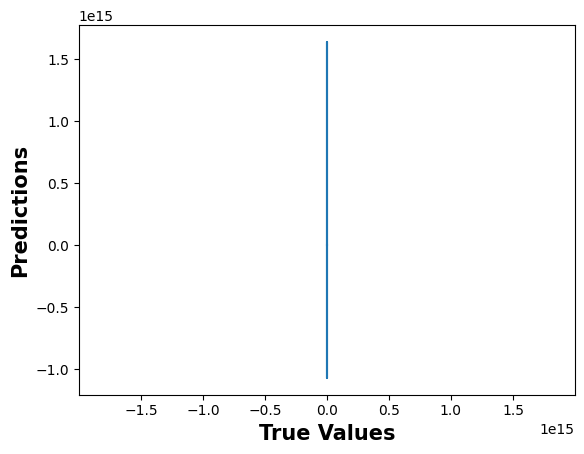

In [489]:
reg = LinearRegression().fit(X_train_encoded, y_train)
y_pred = reg.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
plt.figure(figsize=(10,10))
plt.plot(y_test, y_pred)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
print(p1, p2)
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [490]:
for i in range(len(y_pred)):
    if (abs(y_test.array[i] - y_pred[i]) > 1000000):
        print(i, abs(y_test.array[i] - y_pred[i]))

11 1070058183860413.0
46 1070058183875404.0
155 823746565870796.0
175 915667639539412.0
185 915667639550972.0
215 477929221097288.0
242 825407877433044.0
259 1638989483445218.0
267 1070058183880848.0
360 1070058183906020.0
433 1638989482622704.0
447 421521233492824.0


### P.S. At first it worked well and the error was about 48k, but at one point of time it started to train like this (12 predictions with a very big price) so I excluded this model from the summary

Root mean squared error: 41839.54
Mean squared error: 1750547060.42
Coefficient of determination: 0.73
[51848.26732747 25497.64007867 82318.35610771 27773.05698155
 52900.44874167]
48067.55384741504


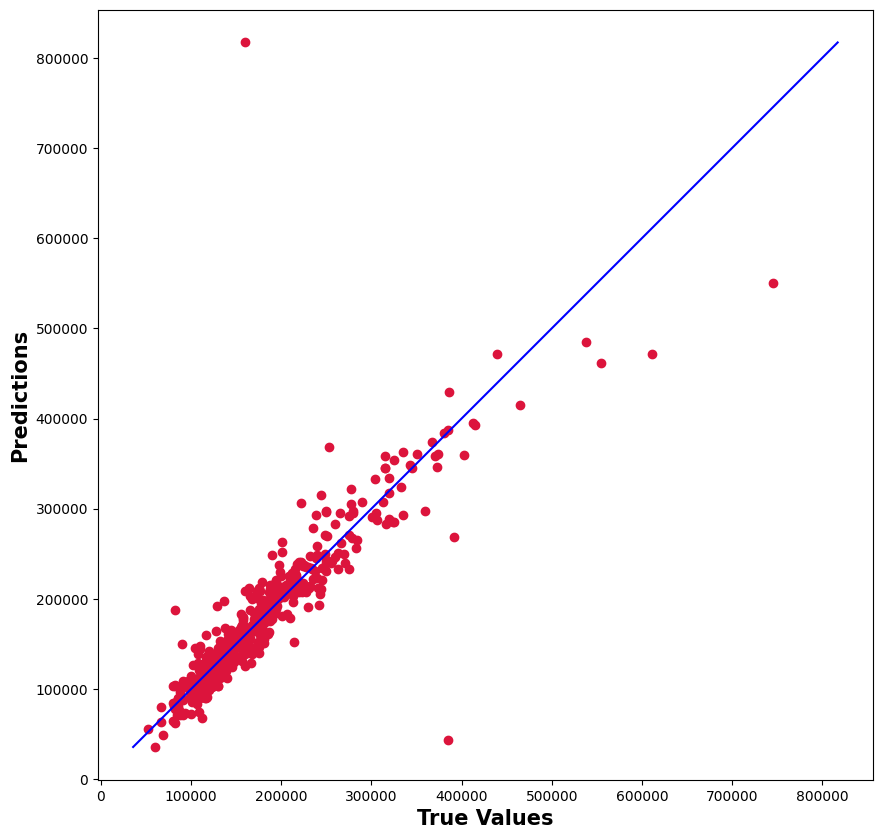

In [491]:
lasso = Lasso(alpha = 50, max_iter=100000).fit(X_train_encoded, y_train)
y_pred = lasso.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
scores = -cross_val_score(lasso, X_test_encoded, y_test, cv=5, scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [492]:
for i in range(len(y_pred)):
    if (abs(y_test.array[i] - y_pred[i]) > 1000000):
        print(i, abs(y_test.array[i] - y_pred[i]))

Root mean squared error: 37541.76
Mean squared error: 1409383702.00
Coefficient of determination: 0.78
[55710.80323264 22491.7467412  82637.71641412 26289.23726197
 33120.56200446]
44050.013130878026


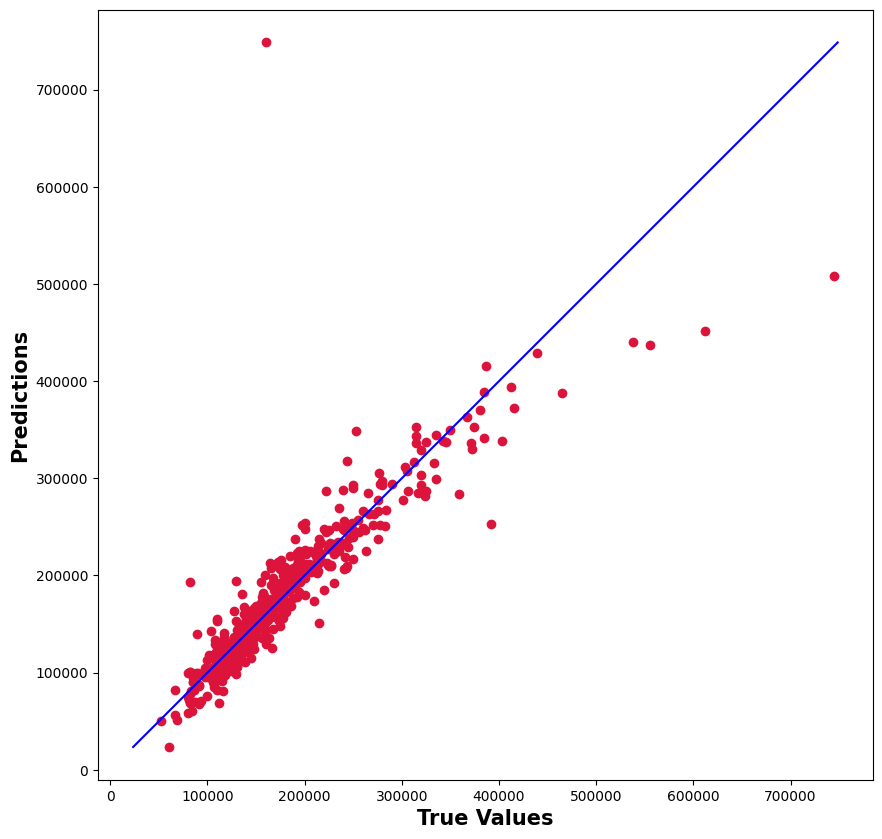

In [271]:
ridge = Ridge(alpha = 50).fit(X_train_encoded, y_train)
y_pred = ridge.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

scores = -cross_val_score(ridge, X_test_encoded, y_test, cv=5, scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Root mean squared error: 36804.49
Mean squared error: 1354570222.16
Coefficient of determination: 0.79


c:\users\38095\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


[40992.78689937 42493.10969376 54785.59584462 52919.60070703]
47797.77328619546


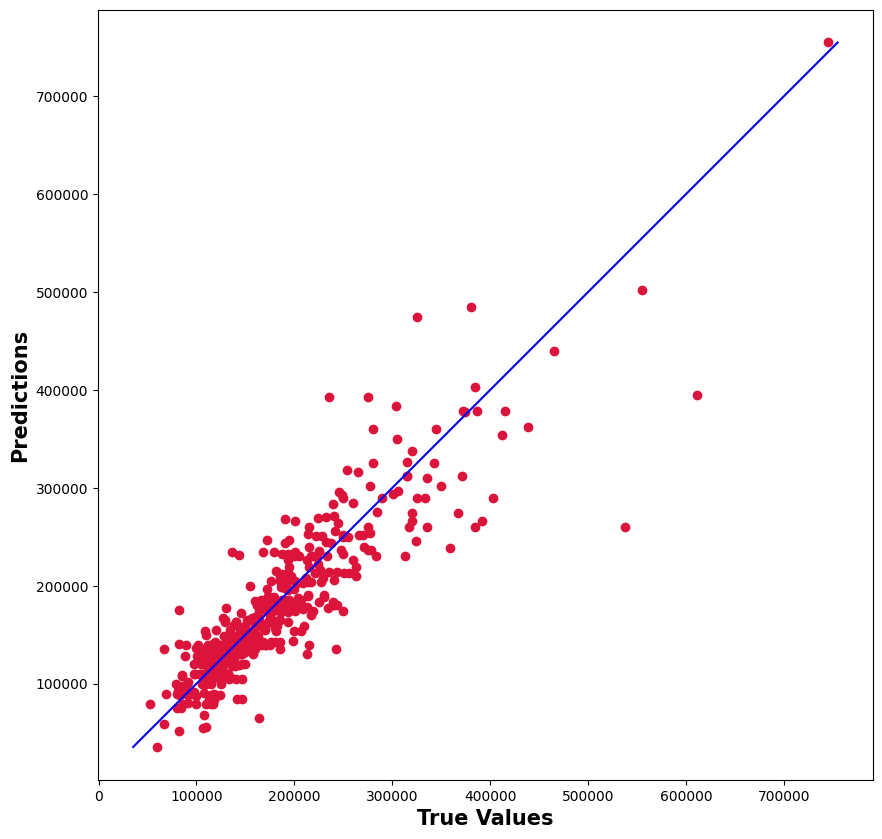

In [273]:
forest = RandomForestClassifier(n_estimators=1000).fit(X_train_encoded, y_train)
y_pred = forest.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

scores = -cross_val_score(forest, X_test_encoded, y_test, cv=4, scoring='neg_root_mean_squared_error')
print(scores)
print(scores.mean())

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [246]:
importantFeatures = pd.DataFrame(data=forest.feature_importances_, index=X_train_encoded.columns, columns=['Importance'])

In [247]:
importantFeatures = importantFeatures.sort_values(by='Importance', ascending=False)

In [248]:
importantFeatures

,Importance
GrLivArea,0.027555
LotArea,0.026582
1stFlrSF,0.026276
BsmtUnfSF,0.026021
GarageArea,0.025631
...,...
18,0.000113
109,0.000105
65,0.000101
88,0.000097


### We can see that forest model performs the best, while lasso and ridge are a bit worse. Let's tune our hyperparameters

In [250]:
X_test_encoded.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,244,245,246,247,248,249,250,251,252,253
0,-0.864423,-1.674078,2.104723,-0.065187,-2.274880,-0.466529,-0.471286,-0.569342,1.786623,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.153101,0.640654,-0.108774,-0.065187,1.291986,-0.995227,-1.688713,-0.569342,-0.097240,0.753673,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.153101,-1.674078,-0.345136,-0.797984,-1.383164,-0.697834,-1.688713,0.312676,-0.600526,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.084006,0.757856,-0.059592,0.667609,-0.491447,0.194342,-0.373892,1.068693,-0.122635,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.455079,-1.058769,-0.854628,-0.065187,-0.491447,-0.003919,-0.666075,1.517920,-1.027628,-0.301270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [164]:
sorted(lassoSearch.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [278]:
ridge = Ridge()
parameters = {'alpha' : [i for i in range(10, 201, 10)]}
ridgeSearch = GridSearchCV(ridge, parameters)
ridgeSearch.fit(X_train_encoded, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
                                   120, 130, 140, 150, 160, 170, 180, 190,
                                   200]})

In [279]:
y_pred = ridgeSearch.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Root mean squared error: 37236.54
Mean squared error: 1386560089.23
Coefficient of determination: 0.79


In [286]:
parameters = {'max_depth' : [i for i in range(30, 101, 30)],
              'n_estimators' : [i for i in range (100, 1001, 300)]}
forest = RandomForestClassifier()
forestSearch = GridSearchCV(forest, parameters)
forestSearch.fit(X_train_encoded, y_train)

c:\users\38095\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [30, 60, 90],
                         'n_estimators': [100, 400, 700, 1000]})

In [287]:
y_pred = forestSearch.predict(X_test_encoded)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Root mean squared error: 41306.24
Mean squared error: 1706205510.75
Coefficient of determination: 0.74


### We can see that it is better for random forest model to define max depth automatically (or we should search for more parameters range, but the training is very long so we will just stop on these results

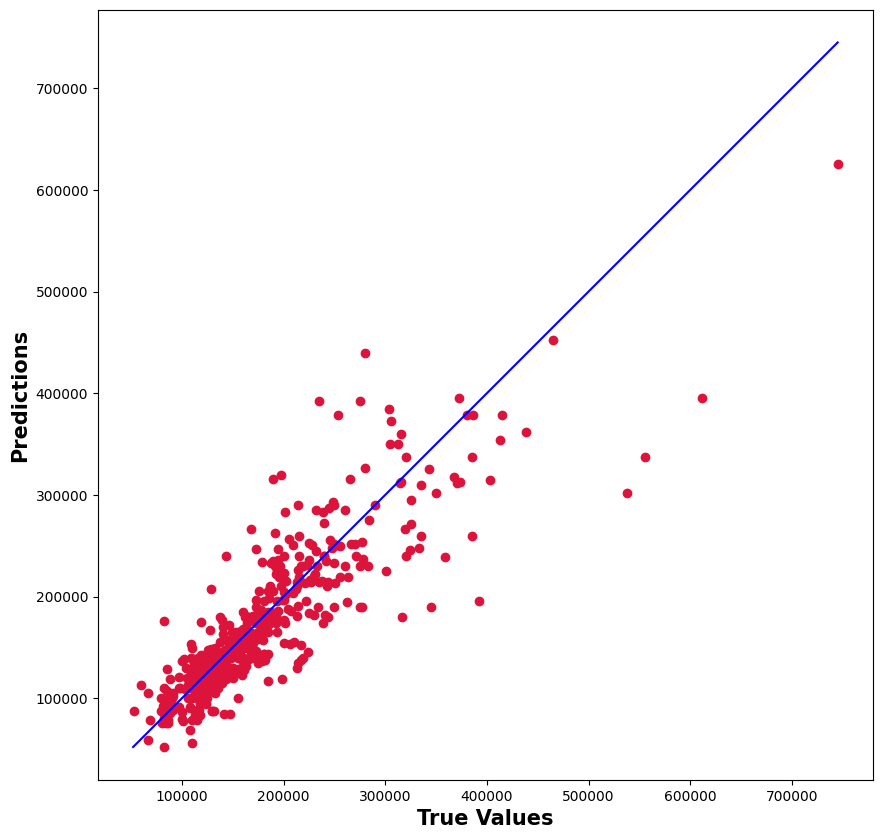

In [291]:

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()